Diagnosis                    0
Radius (mean)                0
Texture (mean)               0
Perimeter (mean)             0
Area (mean)                  0
Smoothness (mean)            0
Compactness (mean)           0
Concavity (mean)             0
Concave points (mean)        0
Symmetry (mean)              0
Fractal dimension (mean)     0
Radius (se)                  0
Texture (se)                 0
Perimeter (se)               0
Area (se)                    0
Smoothness (se)              0
Compactness (se)             0
Concavity (se)               0
Concave points (se)          0
Symmetry (se)                0
Fractal dimension (se)       0
Radius (worst)               0
Texture (worst)              0
Perimeter (worst)            0
Area (worst)                 0
Smoothness (worst)           0
Compactness (worst)          0
Concavity (worst)            0
Concave points (worst)       0
Symmetry (worst)             0
Fractal dimension (worst)    0
dtype: int64
Sample of the raw data:
  

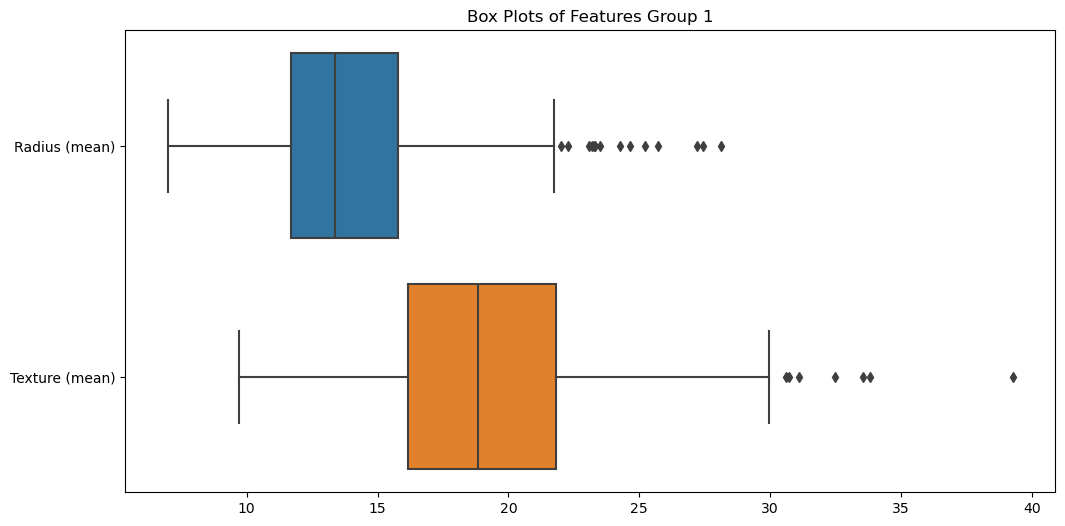

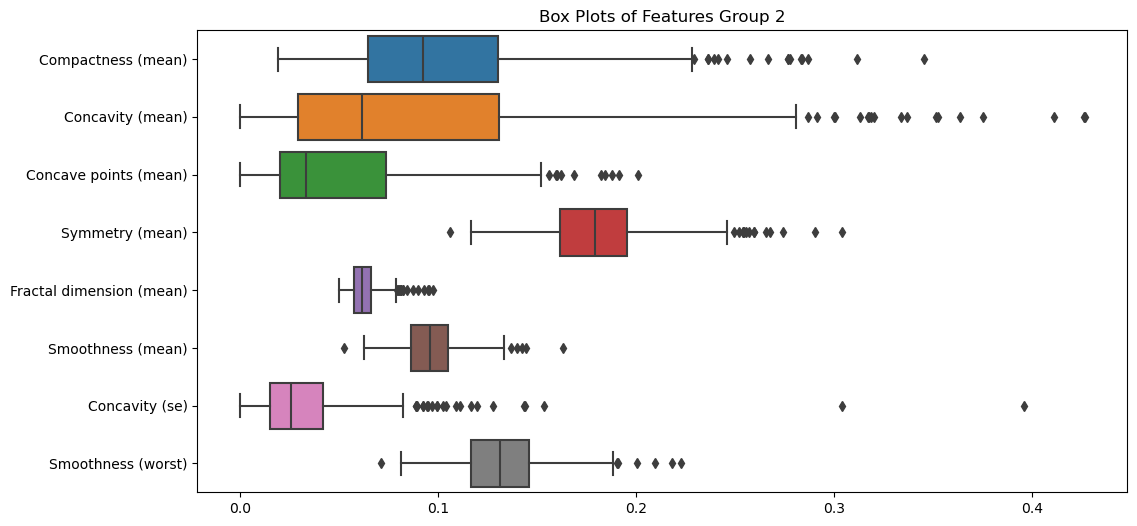

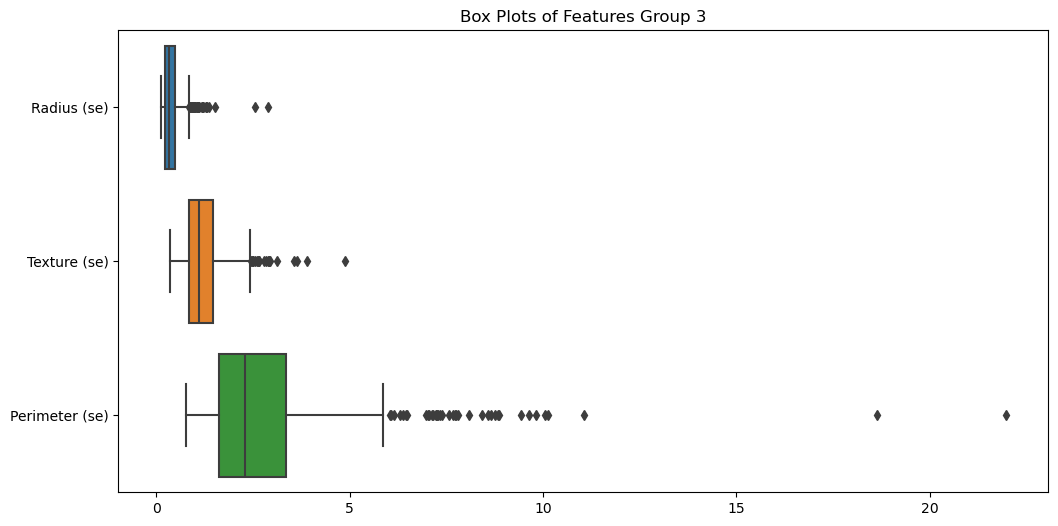

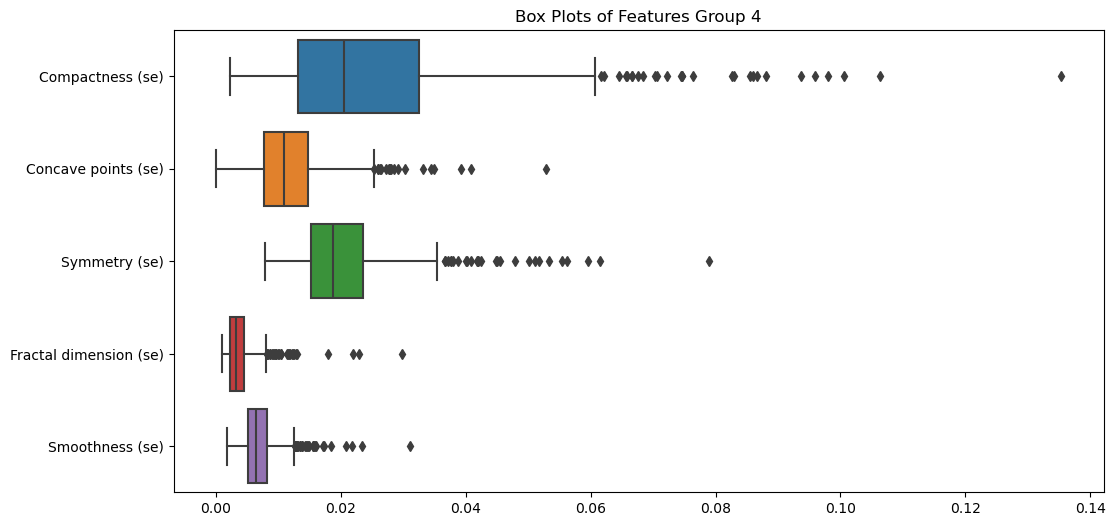

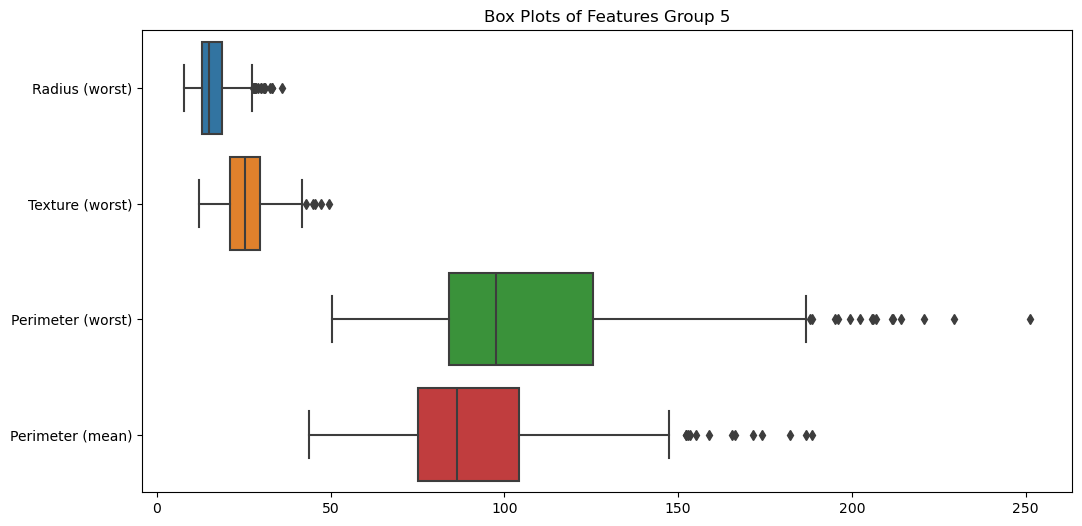

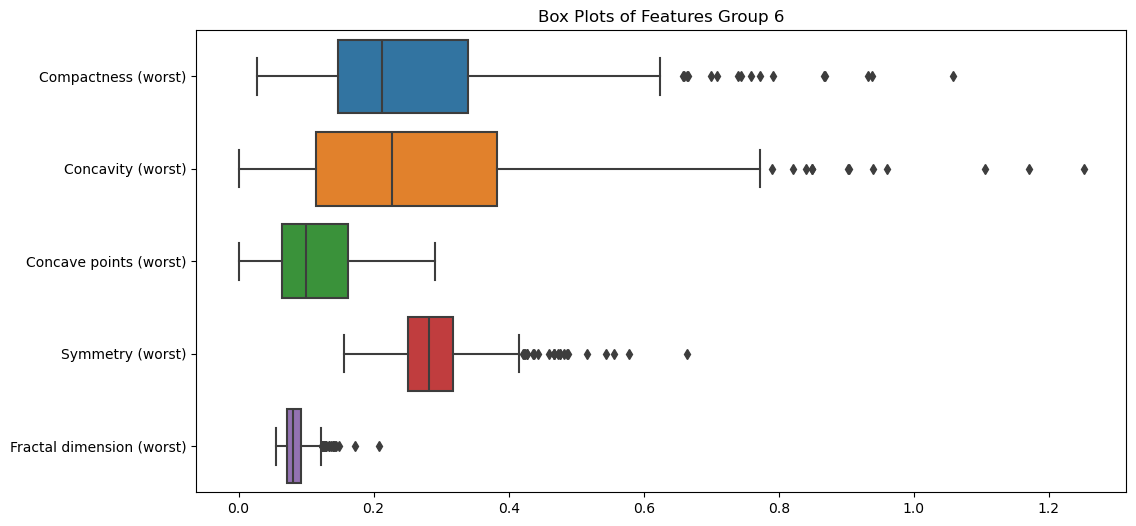

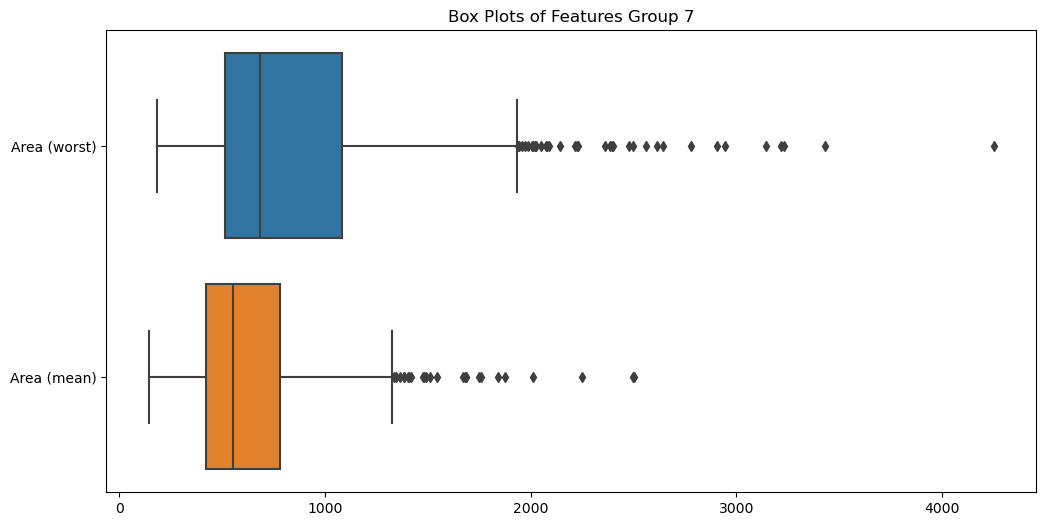

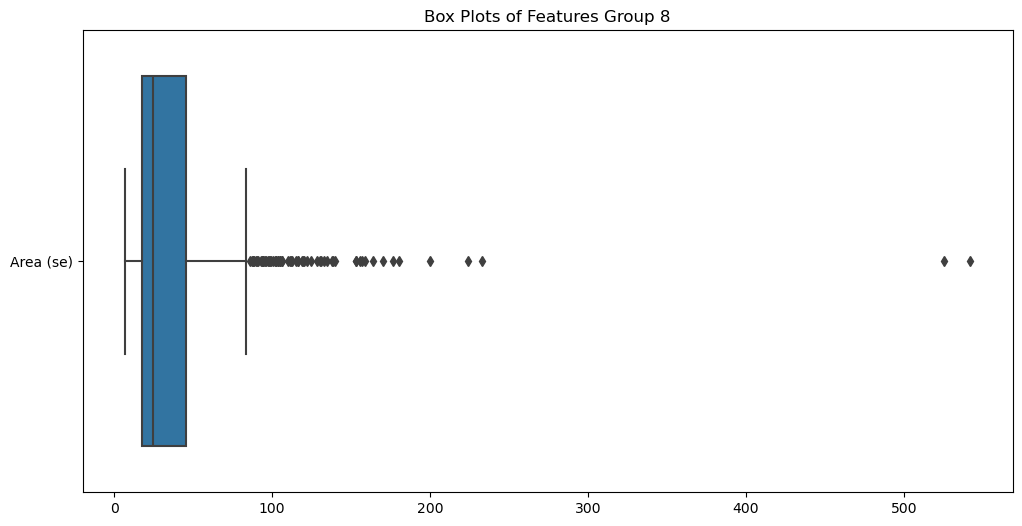

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Url for the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

# Define the column names
column_names = [
    'ID', 'Diagnosis', 'Radius (mean)', 'Texture (mean)', 'Perimeter (mean)', 'Area (mean)', 'Smoothness (mean)',
    'Compactness (mean)', 'Concavity (mean)', 'Concave points (mean)', 'Symmetry (mean)', 'Fractal dimension (mean)',
    'Radius (se)', 'Texture (se)', 'Perimeter (se)', 'Area (se)', 'Smoothness (se)',
    'Compactness (se)', 'Concavity (se)', 'Concave points (se)', 'Symmetry (se)', 'Fractal dimension (se)',
    'Radius (worst)', 'Texture (worst)', 'Perimeter (worst)', 'Area (worst)', 'Smoothness (worst)',
    'Compactness (worst)', 'Concavity (worst)', 'Concave points (worst)', 'Symmetry (worst)', 'Fractal dimension (worst)'
]

# Load the data into a dataframe using the column names above
data = pd.read_csv(url, header=None, names=column_names)

# Drop the ID column
data.drop('ID', axis=1, inplace=True)

# Map diagnosis to binary values
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

# Split the data into features and target
X = data.drop('Diagnosis', axis=1)
y = data['Diagnosis']

# Standardize the feature values to have mean = 0 and variance = 1
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Apply PCA for Logistic Regression and SVM. Lower values for n_components reduced the accuracy of the models
# and higher values had no effect on the accuracy. Therefore, it is not used.
# pca = PCA(n_components=25)
# X_pca = pca.fit_transform(X_standardized)

# Split the data into training and testing sets for Logistic Regression and SVM. Shuffle and stratify the data.
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Split the data into training and testing sets for the Decision Tree,
# but use the original X without scaling or PCA and the original y (not mapped to binary)
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, data['Diagnosis'], test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Check for missing values in the data
missing_values = data.isnull().sum()
print(missing_values)

# Visualize a couple of rows of the raw data
print("Sample of the raw data:")
print(data.head(5))

# Define groups of features for box plots
feature_groups = [
    ['Radius (mean)', 'Texture (mean)'],
    ['Compactness (mean)', 'Concavity (mean)', 'Concave points (mean)', 'Symmetry (mean)', 'Fractal dimension (mean)', 'Smoothness (mean)', 'Concavity (se)', 'Smoothness (worst)'],
    ['Radius (se)', 'Texture (se)', 'Perimeter (se)'],
    ['Compactness (se)', 'Concave points (se)', 'Symmetry (se)', 'Fractal dimension (se)', 'Smoothness (se)'],
    ['Radius (worst)', 'Texture (worst)', 'Perimeter (worst)', 'Perimeter (mean)'],
    ['Compactness (worst)', 'Concavity (worst)', 'Concave points (worst)', 'Symmetry (worst)', 'Fractal dimension (worst)'],
    ['Area (worst)', 'Area (mean)'],
    ['Area (se)'],
]

# Create separate box plots for each group of features
for i, group in enumerate(feature_groups):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=X[group], orient="h")
    plt.title(f'Box Plots of Features Group {i+1}')
    plt.show()


In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define grid search function
def grid_search_for_best_model(model, param_grid, X_train, y_train, model_name="Model"):

    # Initialize the grid search object. 5 fold cross validation is performed. The model with the best parameters is retrained ont the
    # entire dataset. Verbose outputs the intermediary results. n_jobs=-1 uses all cpu cores.
    grid_search = GridSearchCV(model, param_grid, cv=5, refit=True, verbose=2, n_jobs=-1)

    # Perform the grid search using the training data
    grid_search.fit(X_train, y_train)

    # Get the best model, parameters, score, and the cv results
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    cv_results = grid_search.cv_results_

    # Get the cv standard deviation for the test scores of the best model
    std_score = cv_results['std_test_score'][grid_search.best_index_]

    # Display the best parameters, mean CV score, and standard deviation
    print(f"Best parameters for {model_name}:", best_params)
    print(f"Mean CV score for the best {model_name} model:", round(best_score, 3))
    print(f"Standard deviation of CV score for the best {model_name} model: {round(std_score, 3)}")
    
    return best_model

# Define model evaluation function
def evaluate_model(model, X_test, y_test):

   # Evaluate the model on the test set
    y_pred = model.predict(X_test)

    # Display the accuracy score, confusion matrix, and classification report
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

In [3]:
# Author: John Wright
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
logreg = LogisticRegression()

# Define the parameter grid
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.09, 0.1, 0.11, 1, 10],
        'solver': ['liblinear'],
        'max_iter': [100]
    },

    # The saga solver requires a very high max_iter to converge, in this case
    {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['saga'],
        'max_iter': [100000]
    },

    # These solvers only accept l2 so only that option is provided here
    {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs', 'sag'],
        'max_iter': [6000]
    }
]

# Perform grid search and get the best model
best_logreg = grid_search_for_best_model(logreg, param_grid, X_train, y_train, model_name="Logistic Regression")

# Evaluate the best Logistic Regression model on the test set
evaluate_model(best_logreg, X_test, y_test)

# Create a dataframe with a single column containing coefficients of the features. Each row is labeled with the name of the feature.
coefficients = pd.DataFrame(best_logreg.coef_[0], index=X.columns, columns=['Coefficient'])

# Display the coefficients
print(coefficients.sort_values(by='Coefficient', ascending=False))

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best parameters for Logistic Regression: {'C': 0.09, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Mean CV score for the best Logistic Regression model: 0.976
Standard deviation of CV score for the best Logistic Regression model: 0.019
Accuracy: 0.982
Confusion Matrix:
 [[72  0]
 [ 2 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

                           Coefficient
Texture (worst)               0.562815
Radius (worst)                0.489417
Area (worst)                  0.476942
Radius (se)                   0.463429
Perimeter (worst)             0.450167
Concave points (mean)         0.437579
Symmetry (wor

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Mean CV score for the best Decision Tree model: 0.943
Standard deviation of CV score for the best Decision Tree model: 0.027
Accuracy: 0.939
Confusion Matrix:
 [[72  0]
 [ 7 35]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        72
           1       1.00      0.83      0.91        42

    accuracy                           0.94       114
   macro avg       0.96      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



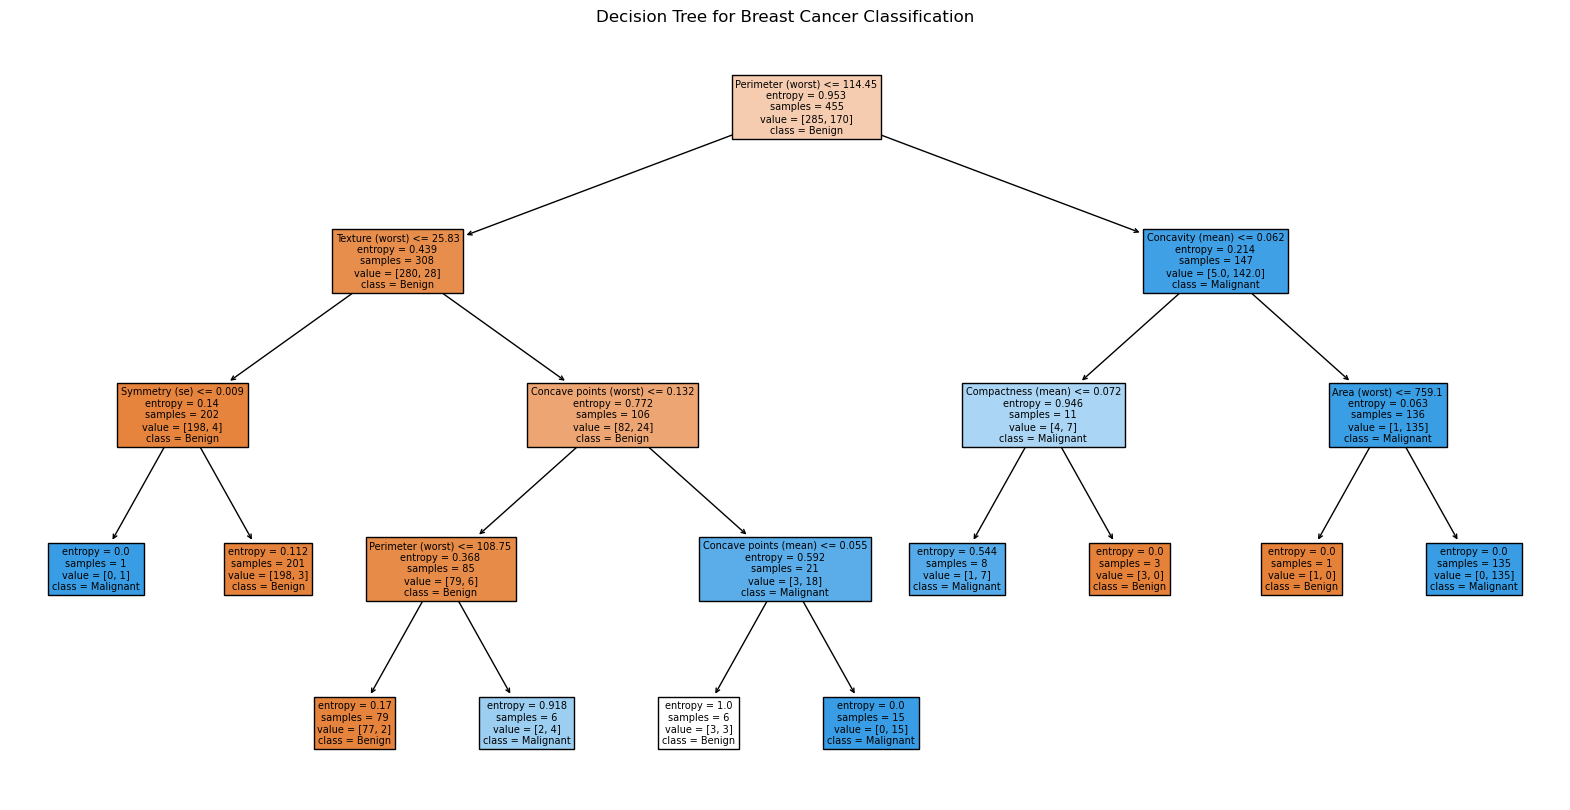

In [4]:
# Author: Ka Ho Chan
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Initialize the Decision Tree model
clf = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
param_grid = {
      'criterion': ['gini', 'entropy'],
      'max_depth': [10, 20, 30],
      'min_samples_split': [2, 5, 10, 15],
      'min_samples_leaf': [1, 2, 4],
      'max_features': [None, 'sqrt', 'log2'],
      'max_leaf_nodes': [5, 10, 20]
       }

# Perform grid search
best_clf = grid_search_for_best_model(clf, param_grid, X_train_dt, y_train_dt, model_name="Decision Tree")

# Evaluate the best Decision Tree model on the test set
evaluate_model(best_clf, X_test_dt, y_test_dt)

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_clf, feature_names=X.columns, class_names=['Benign', 'Malignant'], filled=True)
plt.title("Decision Tree for Breast Cancer Classification")
plt.show()

In [5]:
# Author: John Wright
from sklearn.svm import SVC

# Initialize SVM model.
svm = SVC(probability=True)

# Define Parameter Grid
param_grid = {
      'C': [0.01, 0.1, 0.2],
      'gamma': [0.08, 0.09, 0.1, 0.11, 'scale'],
      'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'degree': [2, 3, 4],
      'coef0': [1.6, 1.7, 1.8, 1.9]
      }

# Perform grid search
best_svm = grid_search_for_best_model(svm, param_grid, X_train, y_train, model_name="SVM")

# Evaluate the best SVM model on the test set
evaluate_model(best_svm, X_test, y_test)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters for SVM: {'C': 0.01, 'coef0': 1.8, 'degree': 4, 'gamma': 0.09, 'kernel': 'poly'}
Mean CV score for the best SVM model: 0.978
Standard deviation of CV score for the best SVM model: 0.016
Accuracy: 0.956
Confusion Matrix:
 [[72  0]
 [ 5 37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



In [6]:
from sklearn.ensemble import BaggingClassifier

# Initialize the BaggingClassifier with the best logreg model
bagging_logreg = BaggingClassifier(estimator=best_logreg, random_state=42)

# Define the parameter grid
bagging_param_grid = {
    'n_estimators': [10, 20, 30],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False]
}

# Perform grid search
best_bagging_logreg = grid_search_for_best_model(bagging_logreg, bagging_param_grid, X_train, y_train, model_name="Bagged Logistic Regression")

# Evaluate the best Bagged Logistic Regression model on the test set
evaluate_model(best_bagging_logreg, X_test, y_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters for Bagged Logistic Regression: {'bootstrap': True, 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 20}
Mean CV score for the best Bagged Logistic Regression model: 0.98
Standard deviation of CV score for the best Bagged Logistic Regression model: 0.013
Accuracy: 0.982
Confusion Matrix:
 [[72  0]
 [ 2 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [7]:
import xgboost as xgb

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss')

# Define the parameter grid
param_grid = {
    'n_estimators': [83, 84, 85],
    'learning_rate': [0.08, 0.09, 0.1],
    'max_depth': [4, 5, 6],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.2, 0.3, 0.4],
    'gamma': [0.09, 0.1, 0.11]
}

# Perform grid search
best_xgb = grid_search_for_best_model(xgb_model, param_grid, X_train, y_train, model_name="XGBoost")

# Evaluate the best XGBoost model on the test set
evaluate_model(best_xgb, X_test, y_test)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters for XGBoost: {'colsample_bytree': 0.2, 'gamma': 0.09, 'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 84, 'subsample': 0.8}
Mean CV score for the best XGBoost model: 0.971
Standard deviation of CV score for the best XGBoost model: 0.027
Accuracy: 0.974
Confusion Matrix:
 [[72  0]
 [ 3 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



<Figure size 20000x10000 with 0 Axes>

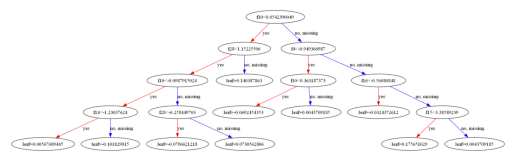

In [8]:
from xgboost import plot_tree

# Plot the first XGBoost tree.
plt.figure(figsize=(20, 10), dpi=1000)
plot_tree(best_xgb, num_trees=0)
plt.show()

In [9]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize AdaBoost with the best SVM model
ada_boost_svm = AdaBoostClassifier(estimator=best_svm, random_state=42)

# Define the parameter grid
param_grid_boost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Perform grid search
best_ada_boost_svm = grid_search_for_best_model(ada_boost_svm, param_grid_boost, X_train, y_train, model_name="AdaBoosted SVM")

# Evaluate the best model on the test set
evaluate_model(best_ada_boost_svm, X_test, y_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\jdwri\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters for AdaBoosted SVM: {'algorithm': 'SAMME.R', 'learning_rate': 0.01, 'n_estimators': 100}
Mean CV score for the best AdaBoosted SVM model: 0.976
Standard deviation of CV score for the best AdaBoosted SVM model: 0.015
Accuracy: 0.982
Confusion Matrix:
 [[72  0]
 [ 2 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [10]:
from sklearn.ensemble import StackingClassifier

# Define base models
base_models = [
    ('logreg', best_logreg),
    ('bagging_logreg', best_bagging_logreg),
    ('decision_tree', best_clf),
    ('xgboost', best_xgb),
    ('svm', best_svm),
    ('ada_svm', best_ada_boost_svm)
]

# Initialize the final classifier
meta_model = LogisticRegression()

# Initialize the stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Define the parameter grid
stacking_param_grid = [
    {
        'final_estimator__C': [0.01, 0.1, 1, 10],
        'final_estimator__penalty': ['l1', 'l2'],
        'final_estimator__solver': ['liblinear'],
        'final_estimator__max_iter': [100]
    },

    # It takes 25 minutes to run with the following uncommented
    # # Again, the saga solver takes a very high max_iter to converge
    # {
    #     'final_estimator__C': [0.01, 0.1, 1, 10],
    #     'final_estimator__penalty': ['l1', 'l2'],
    #     'final_estimator__solver': ['saga'],
    #     'final_estimator__max_iter': [100000]
    # },
    # # These solvers only accept l2 so only that option is provided here
    # {
    #     'final_estimator__C': [0.01, 0.1, 1, 10],
    #     'final_estimator__penalty': ['l2'],
    #     'final_estimator__solver': ['lbfgs', 'sag'],
    #     'final_estimator__max_iter': [6000]
    # }
]

# Perform grid search
best_stacking_clf = grid_search_for_best_model(stacking_clf, stacking_param_grid, X_train, y_train, model_name="Stacking Classifier")

# Evaluate the best model on the test set
evaluate_model(best_stacking_clf, X_test, y_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for Stacking Classifier: {'final_estimator__C': 1, 'final_estimator__max_iter': 100, 'final_estimator__penalty': 'l1', 'final_estimator__solver': 'liblinear'}
Mean CV score for the best Stacking Classifier model: 0.978
Standard deviation of CV score for the best Stacking Classifier model: 0.016
Accuracy: 0.991
Confusion Matrix:
 [[72  0]
 [ 1 41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.98      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



In [13]:
import pandas as pd

# Define the names for each model
models = [
    'Logistic Regression', 
    'Bagging Logistic Regression', 
    'Decision Tree', 
    'XGBoost', 
    'SVM', 
    'AdaBoosted SVM', 
    'Stacked Classifier'
]

# Define the values of all the metrics
accuracy = [0.982, 0.982, 0.939, 0.956, 0.956, 0.982, 0.991]
mean_cv_score = [0.976, 0.98, 0.943, 0.969, 0.978, 0.976, 0.978]
std_cv_score = [0.019, 0.013, 0.027, 0.025, 0.016, 0.015, 0.016]

precision_class_0 = [0.97, 0.97, 0.91, 0.94, 0.94, 0.97, 0.99]
recall_class_0 = [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
f1_score_class_0 = [0.99, 0.99, 0.95, 0.97, 0.97, 0.99, 0.99]

precision_class_1 = [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
recall_class_1 = [0.95, 0.95, 0.83, 0.88, 0.88, 0.95, 0.98]
f1_score_class_1 = [0.98, 0.98, 0.91, 0.94, 0.94, 0.98, 0.99]

# Define a dictionary 
data = {
    'Model': models,
    'Accuracy': accuracy,
    'Mean CV Score': mean_cv_score,
    'Std CV Score': std_cv_score,
    'Precision Class 0': precision_class_0,
    'Recall Class 0': recall_class_0,
    'F1-Score Class 0': f1_score_class_0,
    'Precision Class 1': precision_class_1,
    'Recall Class 1': recall_class_1,
    'F1-Score Class 1': f1_score_class_1
}

# Create a dataframe
df = pd.DataFrame(data)

# Loop through the metrics
for metric in ['Accuracy', 'Mean CV Score', 'Std CV Score', 
               'Precision Class 0', 'Recall Class 0', 'F1-Score Class 0', 
               'Precision Class 1', 'Recall Class 1', 'F1-Score Class 1']:
    
    # Make another dataframe out of the model column and the current metric column and sort the dataframe by the metric column
    # in ascending order for the Std metric otherwise sort in descending order.
    df_sorted = df[['Model', metric]].sort_values(by=metric, ascending=(metric == 'Std CV Score'))
    
    # Print the title of each comparison table
    print(f"\nRanking by {metric}:\n")
    
    # Print the dataframe
    print(df_sorted.to_string())



Ranking by Accuracy:

                         Model  Accuracy
6           Stacked Classifier     0.991
0          Logistic Regression     0.982
1  Bagging Logistic Regression     0.982
5               AdaBoosted SVM     0.982
3                      XGBoost     0.956
4                          SVM     0.956
2                Decision Tree     0.939

Ranking by Mean CV Score:

                         Model  Mean CV Score
1  Bagging Logistic Regression          0.980
4                          SVM          0.978
6           Stacked Classifier          0.978
0          Logistic Regression          0.976
5               AdaBoosted SVM          0.976
3                      XGBoost          0.969
2                Decision Tree          0.943

Ranking by Std CV Score:

                         Model  Std CV Score
1  Bagging Logistic Regression         0.013
5               AdaBoosted SVM         0.015
4                          SVM         0.016
6           Stacked Classifier         0.016
0